In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xlrd
import os
import seaborn as sns
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.metrics import r2_score, accuracy_score, precision_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

In [2]:
# tweets = pd.read_csv("Data/tweets.csv", encoding = 'unicode_escape')
tweets = pd.read_csv("Data/tweets.csv", encoding = 'iso-8859-1')

In [3]:
tweets

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [4]:
# Rename column names
col_names = ['tweets','emotion_directed','sentiment']
tweets = tweets.set_axis(col_names, axis=1, inplace=False)

In [7]:
# Renaming sentiments to Negative, Positive, Neutral, and I can't tell.
for i in range(len(tweets.sentiment)):
    if tweets.sentiment[i] == 'Negative emotion':
        tweets["sentiment"][i] = "negative"
    elif tweets.sentiment[i] == 'Positive emotion':
        tweets["sentiment"][i] = "positive"
    elif tweets.sentiment[i] == 'No emotion toward brand or product':
        tweets['sentiment'][i] = 'neutral'

In [8]:
# Dropping I can't tell sentiments
tweets = tweets[tweets['sentiment'] != 'I can\'t tell']

In [10]:
# Remove single missing value
tweets = tweets.dropna()

In [11]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3282 entries, 0 to 9088
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweets            3282 non-null   object
 1   emotion_directed  3282 non-null   object
 2   sentiment         3282 non-null   object
dtypes: object(3)
memory usage: 102.6+ KB


In [5]:
tweets['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [6]:
tweets = tweets[tweets['is_there_an_emotion_directed_at_a_brand_or_product'] != 'I can\'t tell']
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8937 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8936 non-null   object
 1   emotion_in_tweet_is_directed_at                     3282 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8937 non-null   object
dtypes: object(3)
memory usage: 279.3+ KB


In [7]:
tweets['tweet_text'] = tweets['tweet_text'].astype('str') 

<ipython-input-7-225e8b29b7b3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['tweet_text'] = tweets['tweet_text'].astype('str')


In [8]:
# Capital letter column function
def capital_letter_ratio(tweet):
    #Initialize count 
    capital_count = 0
    
    # Iterate through tweets for caps
    for c in tweet:
        if c.isupper():
            capital_count += 1
    return capital_count / len(tweet)

#Adds capital letter ratio column
tweets['caps_ratio'] = tweets['tweet_text'].apply(capital_letter_ratio)

<ipython-input-8-77479e8ddcfe>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['caps_ratio'] = tweets['tweet_text'].apply(capital_letter_ratio)


In [9]:
# Exclamation column function
def exc_count(tweet):
    
    punctuation = '!'
    # Initialize count
    count = 0
    
    # Find punctuation
    for punc in punctuation:
        count += tweet.count(punc)
    return count

#Adds count column to the tweets
tweets['!_count'] = tweets['tweet_text'].apply(exc_count)

<ipython-input-9-c5693f7391bb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['!_count'] = tweets['tweet_text'].apply(exc_count)


In [10]:
# Question mark column function
def que_count(tweet):
    
    punctuation = '?'
    # Initialize count
    count = 0
    
    # Find punctuation
    for punc in punctuation:
        count += tweet.count(punc)
    return count

#Adds count column to the tweets
tweets['?_count'] = tweets['tweet_text'].apply(que_count)

<ipython-input-10-9023a543a2d4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['?_count'] = tweets['tweet_text'].apply(que_count)


In [11]:
tweets.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,caps_ratio,!_count,?_count
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,0.118110,1,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,0.071942,0,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,0.088608,0,0
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,0.024390,0,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,0.106870,0,0


<AxesSubplot:>

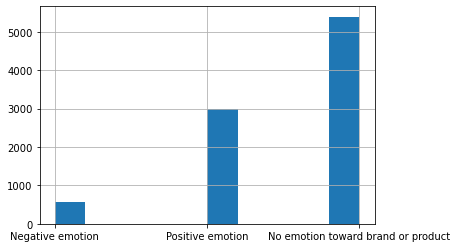

In [12]:
tweets['is_there_an_emotion_directed_at_a_brand_or_product'].hist()

In [13]:
high_que = tweets[tweets['?_count'] > 2]
high_exc = tweets[tweets['!_count'] > 2]

<AxesSubplot:>

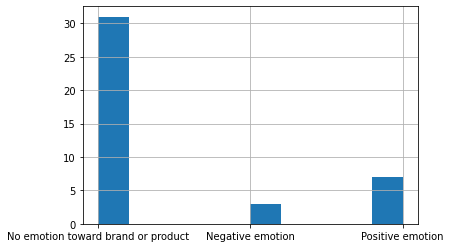

In [16]:
high_que['is_there_an_emotion_directed_at_a_brand_or_product'].hist()

<AxesSubplot:>

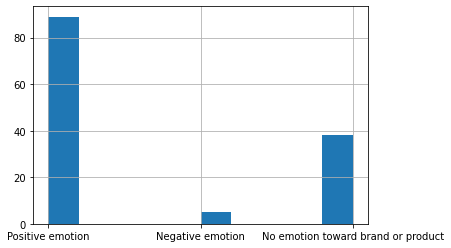

In [15]:
high_exc['is_there_an_emotion_directed_at_a_brand_or_product'].hist()

In [27]:
# Separate tweets by sentiment
positive = tweets[tweets['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion']
negative = tweets[tweets['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion']
neutral = tweets[tweets['is_there_an_emotion_directed_at_a_brand_or_product'] == 'No emotion toward brand or product']

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,caps_ratio,!_count,?_count
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,0.071942,0,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,0.088608,0,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,0.106870,0,0
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,0.057971,0,0
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,0.054264,1,0
...,...,...,...,...,...,...
9072,@mention your iPhone 4 cases are Rad and Ready...,iPhone,Positive emotion,0.045872,2,0
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion,0.041667,0,0
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion,0.085714,2,0
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion,0.094891,0,1


In [28]:
# Print average caps ratio for each sentiment
print(positive['caps_ratio'].mean())
print(negative['caps_ratio'].mean())
print(neutral['caps_ratio'].mean())

0.07532463308340873
0.06432151704731871
0.08188310308102806
